In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

from torchvision.transforms import v2

from dataset import FacialKeypointsDataset

In [2]:
transforms = v2.Compose([
    v2.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225]),
    v2.ToImage(),
    v2.ToDtype(torch.float32),
    # v2.RandomRotation(degrees=(-25, 25)),
    # v2.RandomAffine(degrees=(-15, 15), translate=(0.2, 0.2), scale=(0.8, 1.2), shear=(-10, 10, -10, 10)),
    v2.RandomResizedCrop((224, 224), scale=(0.8, 1.0), antialias=True),
    # v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    # v2.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
    # v2.RandomAutocontrast(p=0.2),
    # v2.RandomEqualize(p=0.2),
])

In [3]:
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv', root_dir='data/test/', transform=transforms, heatmap=True)

(224, 224, 3)
(224, 224, 68)


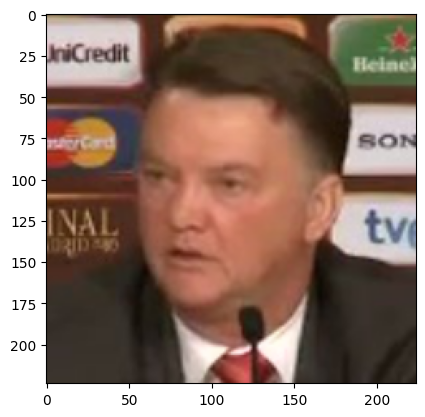

In [5]:
image, keypoints = test_dataset[12]


image = image.permute(1, 2, 0).numpy()
image = (image * 255).astype(np.uint8)
keypoints = keypoints.permute(1, 2, 0).numpy()


print(image.shape)
print(keypoints.shape)

image = image.copy()

plt.imshow(image)


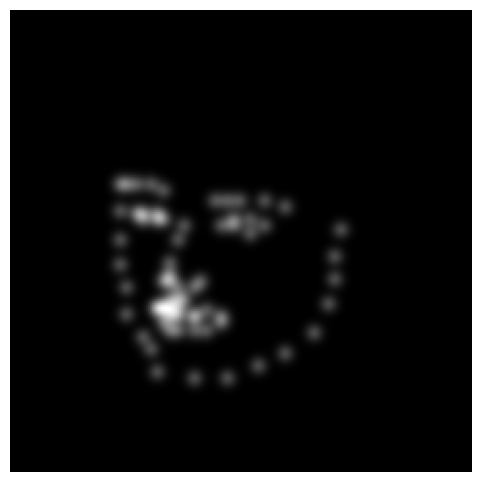

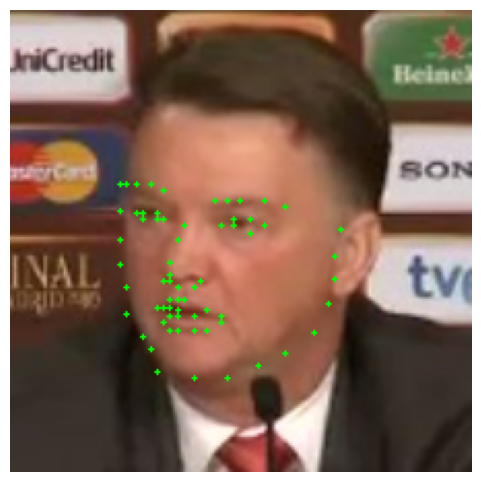

In [6]:
single_heatmap = np.sum(keypoints, axis=2)

# retrieve x and y coordinates from heatmap
key_pts = []
for i in range(68):
    y, x = np.unravel_index(np.argmax(keypoints[:, :, i]), keypoints.shape[:2])
    key_pts.append((x, y))
    
    cv2.circle(image, (x, y), 1, (0, 255, 0), -1)


plt.figure(figsize=(6, 6))
plt.imshow(single_heatmap, cmap='gray')
plt.axis('off')
plt.show()

plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis('off')
plt.show()

In [17]:
from torchvision.models import convnext_tiny
from torchvision.models import ConvNeXt_Tiny_Weights


import torch.nn as nn
import torch
import torch.nn.functional as F


model = convnext_tiny(weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1)

# Freeze model weights
for i in range(6):
    for param in model.features[i].parameters():
        param.requires_grad = False

for i in range(6, 8):
    for name, layer in model.features[i].named_modules():
        if isinstance(layer, torch.nn.Conv2d):
            # print(i, name, layer)
            layer.reset_parameters()

# model.avgpool = torch.nn.Identity()

def _is_contiguous(tensor: torch.Tensor) -> bool:
    # jit is oh so lovely :/
    # if torch.jit.is_tracing():
    #     return True
    if torch.jit.is_scripting():
        return tensor.is_contiguous()
    else:
        return tensor.is_contiguous(memory_format=torch.contiguous_format)

class LayerNorm2d(nn.LayerNorm):
    r""" LayerNorm for channels_first tensors with 2d spatial dimensions (ie N, C, H, W).
    """

    def __init__(self, normalized_shape, eps=1e-6):
        super().__init__(normalized_shape, eps=eps)

    def forward(self, x) -> torch.Tensor:
        if _is_contiguous(x):
            return F.layer_norm(
                x.permute(0, 2, 3, 1), self.normalized_shape, self.weight, self.bias, self.eps).permute(0, 3, 1, 2)
        else:
            s, u = torch.var_mean(x, dim=1, keepdim=True)
            x = (x - u) * torch.rsqrt(s + self.eps)
            x = x * self.weight[:, None, None] + self.bias[:, None, None]
            return x

model.classifier = torch.nn.Sequential(
    LayerNorm2d(768, eps=1e-06),
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(
        in_features=768,
        out_features=68*2,
        bias=True
    )
)

model.to('cuda:0')
model

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [13]:
len(model.features)

8

In [18]:
img = torch.randn(2, 3, 224, 224).to('cuda:0')

output = model(img)
print(output.shape)

# print(output.shape)

torch.Size([2, 136])


In [19]:
from torchinfo import summary

summary(model, (2, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
ConvNeXt                                      [2, 136]                  --
├─Sequential: 1-1                             [2, 768, 7, 7]            --
│    └─Conv2dNormActivation: 2-1              [2, 96, 56, 56]           --
│    │    └─Conv2d: 3-1                       [2, 96, 56, 56]           (4,704)
│    │    └─LayerNorm2d: 3-2                  [2, 96, 56, 56]           (192)
│    └─Sequential: 2-2                        [2, 96, 56, 56]           --
│    │    └─CNBlock: 3-3                      [2, 96, 56, 56]           (79,296)
│    │    └─CNBlock: 3-4                      [2, 96, 56, 56]           (79,296)
│    │    └─CNBlock: 3-5                      [2, 96, 56, 56]           (79,296)
│    └─Sequential: 2-3                        [2, 192, 28, 28]          --
│    │    └─LayerNorm2d: 3-6                  [2, 96, 56, 56]           (192)
│    │    └─Conv2d: 3-7                       [2, 192, 28, 28]    

In [16]:
print(model._get_name())

DeepLabV3
